## Kelley hu4d5-5 VH-R50A charging step error analysis

In this notebook we will use a random forest model to find the most energetically influential degrees of freedom for the VH-R50A charging step TI production run. Next, we will compare the sampling of these DOF during TI production to a free energy profile derived from end state GaMD sampling. We will attempt to  correct any inaccurate sampling in the TI data and find the estimated ddG before and after the correction. 

In [1]:
import os
os.chdir("..")
from common_functions import *

### Ingesting original TI lambda production data

In [2]:
os.chdir("./TI_data/VH-R50A")
geom_dvdls_crg = pd.read_csv("R50A_crg_bound.csv")
dvdls_ub_crg = pd.read_csv("R50A_crg_unbound.csv")
geom_dvdls_vdw = pd.read_csv("R50A_vdw_bound.csv")
dvdls_ub_vdw = pd.read_csv("R50A_vdw_unbound.csv")


### Original TI ddG estimate:

In [5]:
dG_bd_crg = geom_dvdls_crg.groupby("Lambda").mean()["weight_dvdl"].sum()
dG_ubd_crg = dvdls_ub_crg.groupby("Lambda").mean()["weight_dvdl"].sum()
ddG_crg = dG_bd_crg - dG_ubd_crg

dG_bd_vdw = geom_dvdls_vdw.groupby("Lambda").mean()["weight_dvdl"].sum()
dG_ubd_vdw = dvdls_ub_vdw.groupby("Lambda").mean()["weight_dvdl"].sum()
ddG_vdw = dG_bd_vdw - dG_ubd_vdw

empirical_value = 4.58

error = abs((ddG_crg + ddG_vdw) - empirical_value)

print("Original ddG (crg step): ")
print(f"{round(ddG_crg, 4)} kcal/mol")

print("Original ddG (vdw step): ")
print(f"{round(ddG_vdw, 4)} kcal/mol")

print("Original total ddG: ")
print(f"{round(ddG_crg + ddG_vdw, 4)} kcal/mol")

print()
print("Empirical value: ")
print(f"{empirical_value} kcal/mol")

print("Original ddG error: ")
print(f"{round(error, 4)} kcal/mol")

Original ddG (crg step): 
0.9958 kcal/mol
Original ddG (vdw step): 
1.9825 kcal/mol
Original total ddG: 
2.9783 kcal/mol

Empirical value: 
4.58 kcal/mol
Original ddG error: 
1.6017 kcal/mol


### Charging step RF model

#### Splitting data into independent/dependent variables for random forest model

See our methods/supplemental methods section for our process to choose the input features.

In [7]:
X = geom_dvdls_crg.drop(
    ["weight_dvdl", "dvdl", "Run", "Lambda", "#Frame"], axis=1
)

X_scl = pd.DataFrame(StandardScaler().fit_transform(X))
X_scl.columns = X.columns
Y = geom_dvdls_crg["weight_dvdl"]


#### Checking to see if there is any cross-correlations within the dataset

In [8]:
absCorr = abs(X_scl.corr())
for i in absCorr.columns:
    for j in absCorr.index:
        cor = absCorr.loc[i, j]
        if abs(cor) > 0.5 and i != j:
            print(i, j)
            print(cor)
            

#### Using random forest model to identify the most influential degrees of freedom

We run our model 25 times, then sort the results by the mean of feature importance across the 25 iterations. 

In [9]:
rfeDefault = RFE(estimator=DecisionTreeRegressor(max_depth=5, random_state=42), n_features_to_select=0.75, step=0.05)
rfDefault = RandomForestRegressor(
    max_depth=10, n_estimators=200, oob_score=True, max_features=0.6, min_samples_leaf = 7, min_samples_split=14, random_state=42
)

pipelineDefault_rf = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('feature_selection', rfeDefault),
    ('regression_model', rfDefault)
])


imps = benchmark_model(pipelineDefault_rf, X_scl, Y, geom_dvdls_crg["Lambda"])
imps[["Mean", "Median"]].sort_values(by="Mean", ascending=False)[:15]

0.7997257648463655
0.0005903379284606613
0.7312988758683645
0.0034535125498715907


,Mean,Median
E71_R399,0.147139,0.147601
R399_chi1,0.097074,0.056015
V397_chi1,0.092797,0.146901
T229_R399,0.091266,0.091049
E71_chi3,0.046551,0.046545
F68_chi1,0.045415,0.045675
E71_chi2,0.044603,0.044359
H384_chi1,0.043651,0.047092
F86_chi2,0.042237,0.042305
R408_chi4,0.041260,0.063360


### Comparing the GaMD pmf of VH-R50...Ag-E71 distance to the TI sampling

Based on the RF model indicating that the salt bridge between Ag-E71 and VH-R50 is the most important feature, we will compare the GaMD pmf profile of this distance to what was sampled during TI.

If we check the GaMD profile, the main peak appears to be from 3.6 A - 4.8 A, suggesting a salt bridge. Most frames during TI do not contain this salt bridge. 

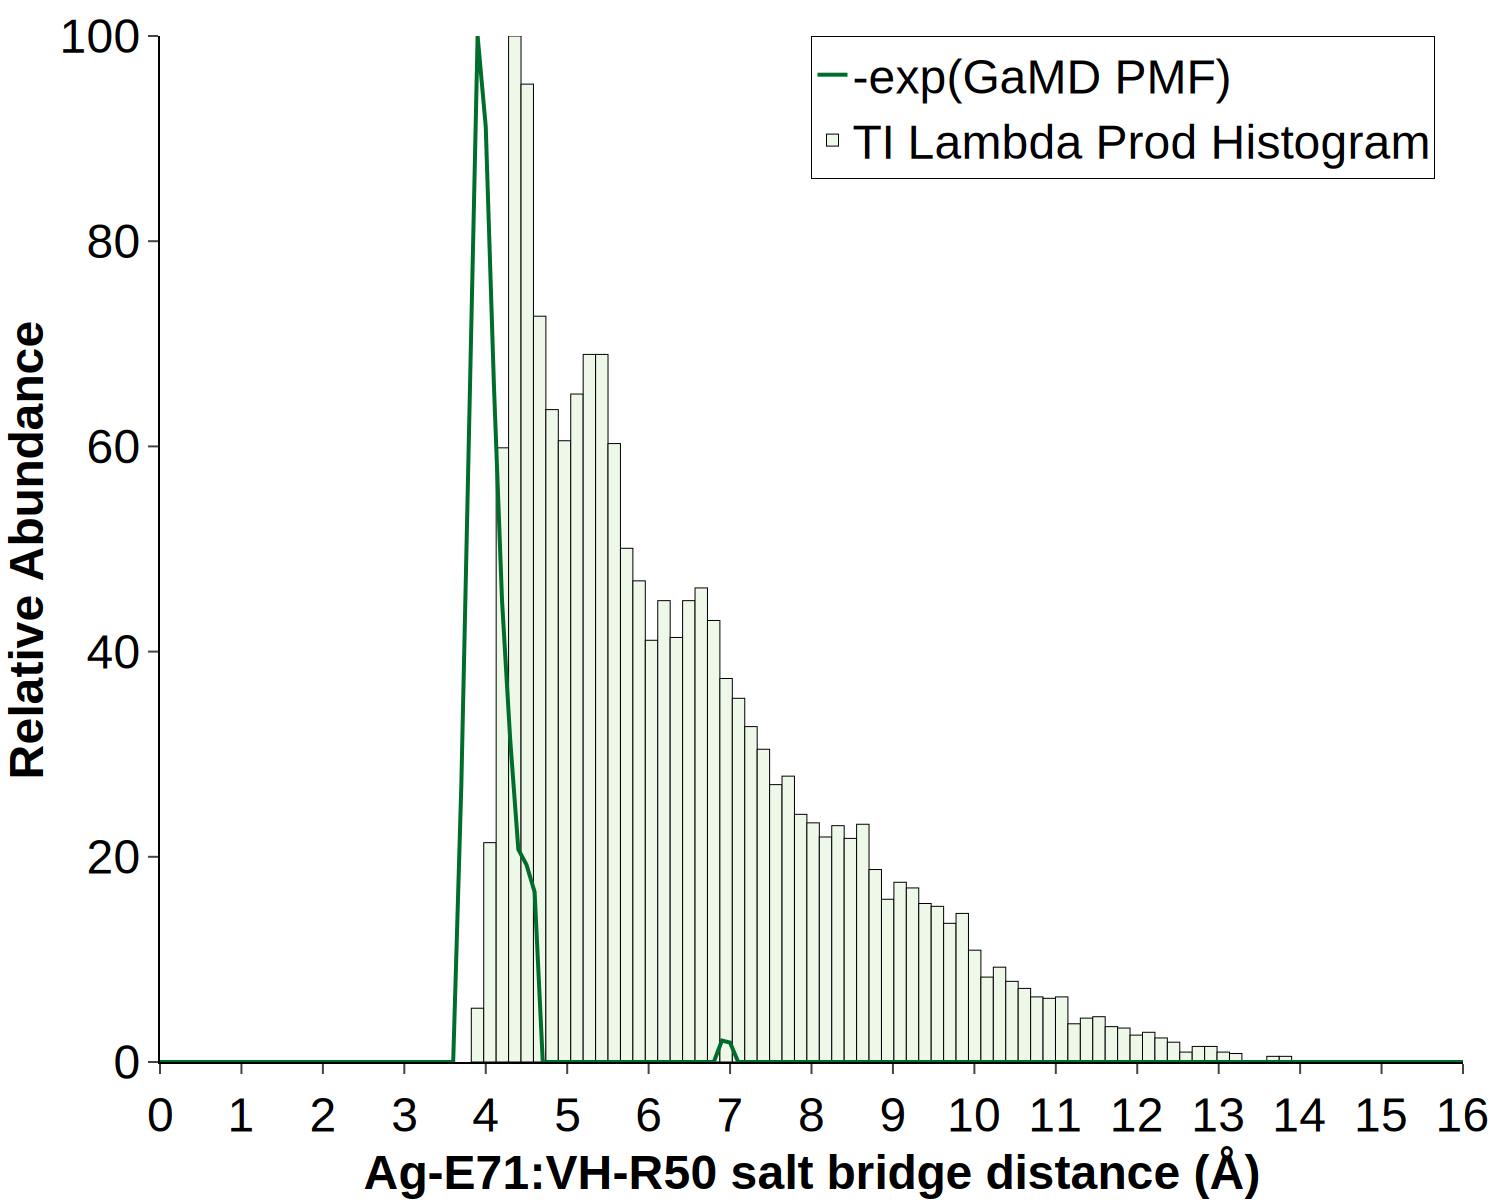

In [9]:
os.chdir("../../gamd_pmfs/VH-R50A")
E71_R399 = get_pmf(
    "pmf-c2-E71_R399_conv_300ns.dat.xvg"
)

pio.renderers.default="jupyterlab"
fig = plot_pmf_TI_1D_fig(E71_R399, geom_dvdls_crg, "E71_R399", scaler=100, bins=75).update_layout(
    width=1500,
    height=1200,
    barmode="overlay",
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),
    legend=dict(
        font=dict(size=48, color="black", family="Arial"),
        bordercolor="black",
        borderwidth=1,
        x=0.5, y=1
    )
).update_xaxes(
    range=[0,16],
    showline=True,
    linewidth=2,
    linecolor="black",
    dtick=1.0,
    ticks="outside", ticklen=10, tickwidth=2,
    tickfont=dict(size=48, color="black", family="Arial"),
    title=dict(
        text="<b>Ag-E71:VH-R50 salt bridge distance (Å)</b>" ,
        font=dict(family="Arial", size=48, color="black")
    )
).update_yaxes(
    range=[0, 100],
    linewidth=2,
    linecolor="black",
    tickfont=dict(size=48, color="black", family="Arial"),
    ticks="outside", ticklen=10, tickwidth=2,
    title=dict(
        text="<b>Relative Abundance</b>",
        font=dict(family="Arial", size=48, color="black")
    )
)
fig.show(renderer="svg")

# os.chdir("/gstore/scratch/u/sastrys1/thermo-integration/paper_notebooks/")
# fig.write_image("orig_r50_sb.png", width=1500, height=1200)

### Filtering-based TI correction

As a possible way to mitigate this incorrect sampling by TI, we filter the TI sampling only to frames in which the charged end state retains the salt bridge. Almost zero frames have interatomic distance between 3.6 A and 4.5 A (the main part of the GaMD pmf). 

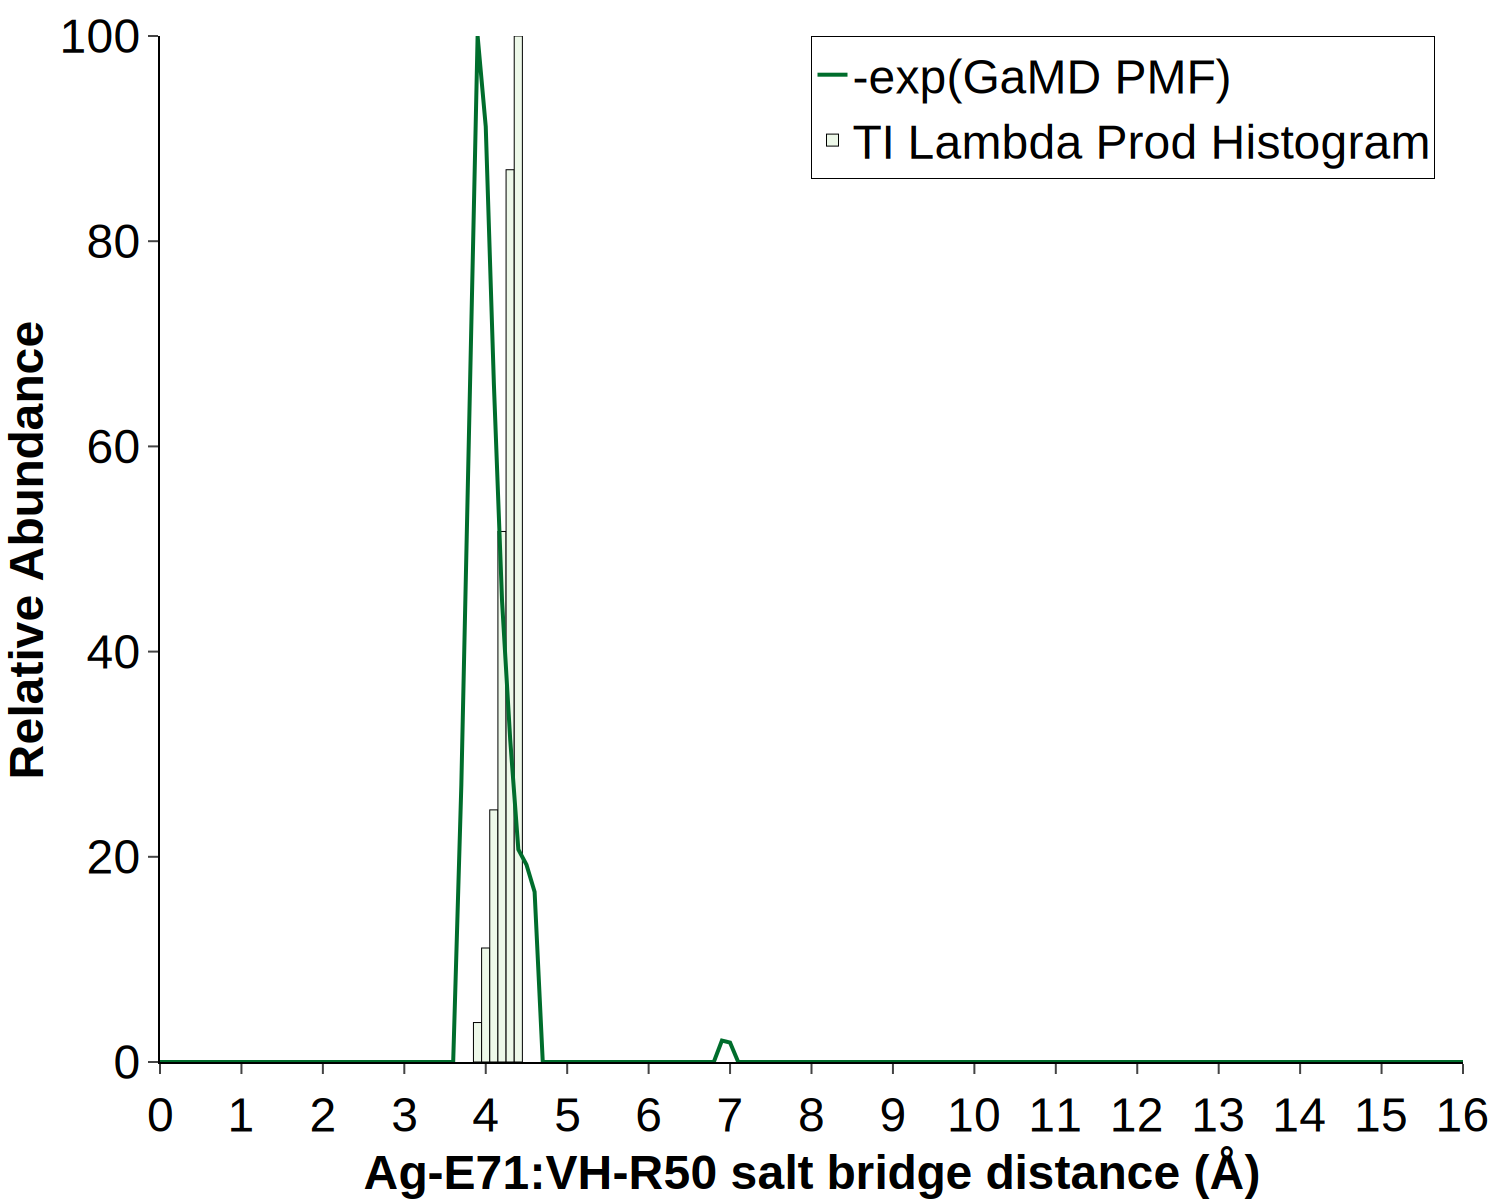

In [10]:
filt = geom_dvdls_crg[(geom_dvdls_crg["E71_R399"] > 3.6) & (geom_dvdls_crg["E71_R399"] < 4.5)]

fig_filt = plot_pmf_TI_1D_fig(E71_R399, filt, "E71_R399", scaler=100, bins=6).update_layout(
    width=1500,
    height=1200,
    barmode="overlay",
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),
    legend=dict(
        font=dict(size=48, color="black", family="Arial"),
        bordercolor="black",
        borderwidth=1,
        x=0.5, y=1
    )
).update_xaxes(
    range=[0,16],
    showline=True,
    linewidth=2,
    linecolor="black",
    dtick=1.0,
    ticks="outside", ticklen=10, tickwidth=2,
    tickfont=dict(size=48, color="black", family="Arial"),
    title=dict(
        text="<b>Ag-E71:VH-R50 salt bridge distance (Å)</b>" ,
        font=dict(family="Arial", size=48, color="black")
    )
).update_yaxes(
    range=[0, 100],
    linewidth=2,
    linecolor="black",
    tickfont=dict(size=48, color="black", family="Arial"),
    ticks="outside", ticklen=10, tickwidth=2,
    title=dict(
        text="<b>Relative Abundance</b>",
        font=dict(family="Arial", size=48, color="black")
    )
)
fig_filt.show(renderer="svg")

# os.chdir("/gstore/scratch/u/sastrys1/thermo-integration/paper_notebooks/")
# fig_filt.write_image("filt_r50_sb.png", width=1500, height=1200)


#### Filtering correction, original run

Here, we will simply filter the original TI run to just the frames that fit into the GaMD profile, then compute the ddG. We will have to substitute the global average for lambdas 8-12 because of insufficient sampling. In this extremely small sample size, we find that the estimate gets much more accurate when using only the frames that contain the energetically influential salt bridge. However, there are far too many lambdas with insufficient frames for this result to be meaningful.

We are not correcting the unbound run since this is an Ag---Ab distance, and this same distance is not present in the unbound state.

Furthermore, we are not adding in vdw step corrections here because the model $R^2$ did not convey a strong enough relationship between the geometric and energetic degrees of freedom. (see the R50A vdw step notebook).

In [13]:
print(geom_dvdls_crg[(geom_dvdls_crg["E71_R399"] > 3.6) & (geom_dvdls_crg["E71_R399"] < 4.5)].groupby("Lambda").count()["weight_dvdl"])

dG_filt = geom_dvdls_crg[(geom_dvdls_crg["E71_R399"] > 3.6) & (geom_dvdls_crg["E71_R399"] < 4.5)].groupby("Lambda").mean()["weight_dvdl"]
dG_tot = geom_dvdls_crg.groupby("Lambda").mean()["weight_dvdl"]

dG_filt.loc[8] = dG_tot.loc[8]
dG_filt.loc[9] = dG_tot.loc[9]
dG_filt.loc[10] = dG_tot.loc[10]
dG_filt.loc[11] = dG_tot.loc[11]
dG_filt.loc[12] = dG_tot.loc[12]

print("Original crg step ddG: ")
print(f"{round(ddG_crg, 4)} kcal/mol")
    
print("\nFilter-corrected crg step ddG: ")
print(f"{round(dG_filt.sum() - dG_ubd_crg, 4)} kcal/mol")

print("Total filter-corrected ddG: ")
print(f"{round((dG_filt.sum() - dG_ubd_crg) + ddG_vdw, 4)} kcal/mol")

print("Empirical value: ")
print(f"{empirical_value} kcal/mol")

Lambda
1     221
2     203
3     232
4     178
5      97
6     189
7     116
8      61
9       4
11      1
Name: weight_dvdl, dtype: int64
Original crg step ddG: 
0.9958 kcal/mol

Filter-corrected crg step ddG: 
2.3674 kcal/mol
Total filter-corrected ddG: 
4.3499 kcal/mol
Empirical value: 
4.58 kcal/mol


### Restraints-based correction

We realized that charge-changing perturbations can prevent salt bridges from being properly sampled during TI, which is why so few TI frames contain the salt bridge that we expect to see during GaMD. Thus, we added distance-based NMR restraints to both end states to ensure that the integrity of the salt bridge was retained during TI lambda production. 

#### Ingesting restrained salt bridge run

In [17]:
os.chdir("../../TI_data/VH-R50A")
geom_dvdls_rst = pd.read_csv("R50A_crg_rst_bound.csv")


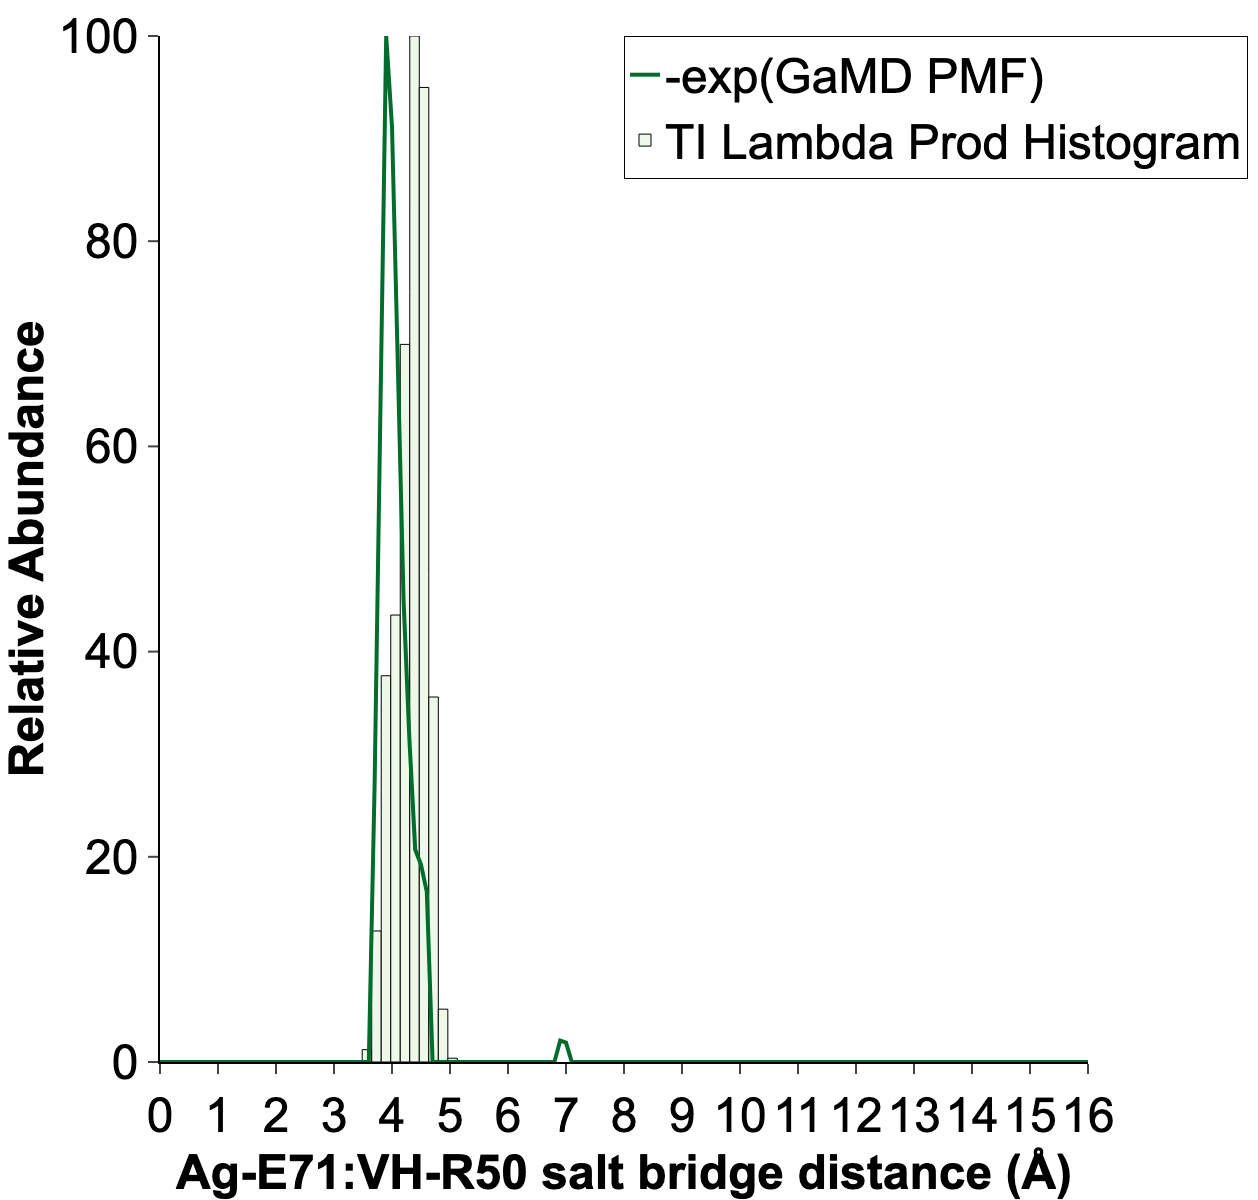

In [18]:
fig_rst = plot_pmf_TI_1D_fig(E71_R399, geom_dvdls_rst, "E71_R399_ion", scaler=100, bins=10).update_layout(
    width=1500,
    height=1200,
    barmode="overlay",
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),
    legend=dict(
        font=dict(size=48, color="black", family="Arial"),
        bordercolor="black",
        borderwidth=1,
        x=0.5, y=1
    )
).update_xaxes(
    range=[0,16],
    showline=True,
    linewidth=2,
    linecolor="black",
    dtick=1.0,
    ticks="outside", ticklen=10, tickwidth=2,
    tickfont=dict(size=48, color="black", family="Arial"),
    title=dict(
        text="<b>Ag-E71:VH-R50 salt bridge distance (Å)</b>" ,
        font=dict(family="Arial", size=48, color="black")
    )
).update_yaxes(
    range=[0, 100],
    linewidth=2,
    linecolor="black",
    tickfont=dict(size=48, color="black", family="Arial"),
    ticks="outside", ticklen=10, tickwidth=2,
    title=dict(
        text="<b>Relative Abundance</b>",
        font=dict(family="Arial", size=48, color="black")
    )
)
fig_rst.show(renderer="jupyterlab")

# os.chdir("/gstore/scratch/u/sastrys1/thermo-integration/paper_notebooks/images")
# fig_filt_rst.write_image("rst_r50_sb.png", width=1500, height=1200)


#### Correction using the restrained NMR run 

Using NMR restraints during the bound state charging step to enforce the Ag-E71...VH-R50 salt bridge results in a > 2 kcal/mol change in the charging step ddG and thus the total ddG.

In [20]:
dG_rst = geom_dvdls_rst.groupby("Lambda").mean()["weight_dvdl"]

print("Original total ddG: ")
print(f"{round(ddG_vdw + ddG_crg, 4)} kcal/mol")
print()
print("Total ddG, with NMR restraints: ")
print(f"{round(dG_rst.sum() - dG_ubd_crg + (ddG_vdw), 4)} kcal/mol")


print()
print("Empirical value: ")
print(f"{empirical_value} kcal/mol")

Original total ddG: 
2.9783 kcal/mol

Total ddG, with NMR restraints: 
5.1398 kcal/mol

Empirical value: 
4.58 kcal/mol


## One-step transformation 

In order to ensure that these broken salt bridges were not due to our two-step protocol for handling charge-changing mutations, we decided to perform a one-step protocol with smoothstep potentials to see if the same errors would exist and could be alleviated by the same restraints. 

#### Data ingestion

In [25]:
# bound state charging step
os.chdir("../../TI_data/VH-R50A")
geom_dvdls_oneStep = pd.read_csv("R50A_oneStep_bound.csv")
dvdls_oneStep_ub = pd.read_csv("R50A_oneStep_unbound.csv")


#### Initial estimate

In [26]:
dG_bd_oneStep = dvdls_oneStep.groupby("Lambda").mean()["weight_dvdl"].sum()
dG_ubd_oneStep = dvdls_oneStep_ub.groupby("Lambda").mean()["weight_dvdl"].sum()
ddG_oneStep = dG_bd_oneStep - dG_ubd_oneStep

print("Original ddG (one step): ")
print(f"{round(ddG_oneStep, 4)} kcal/mol")

print()
print("Empirical value: ")
print(f"{empirical_value} kcal/mol")

Original ddG (one step): 
2.2748 kcal/mol

Empirical value: 
4.58 kcal/mol


#### Visualizing salt bridge distance compared to GaMD pmf

Similar to the two-step charging step, the salt bridge between VH-R50 and Ag-E71 is only retained in a small minority of TI frames during the one step transformation.

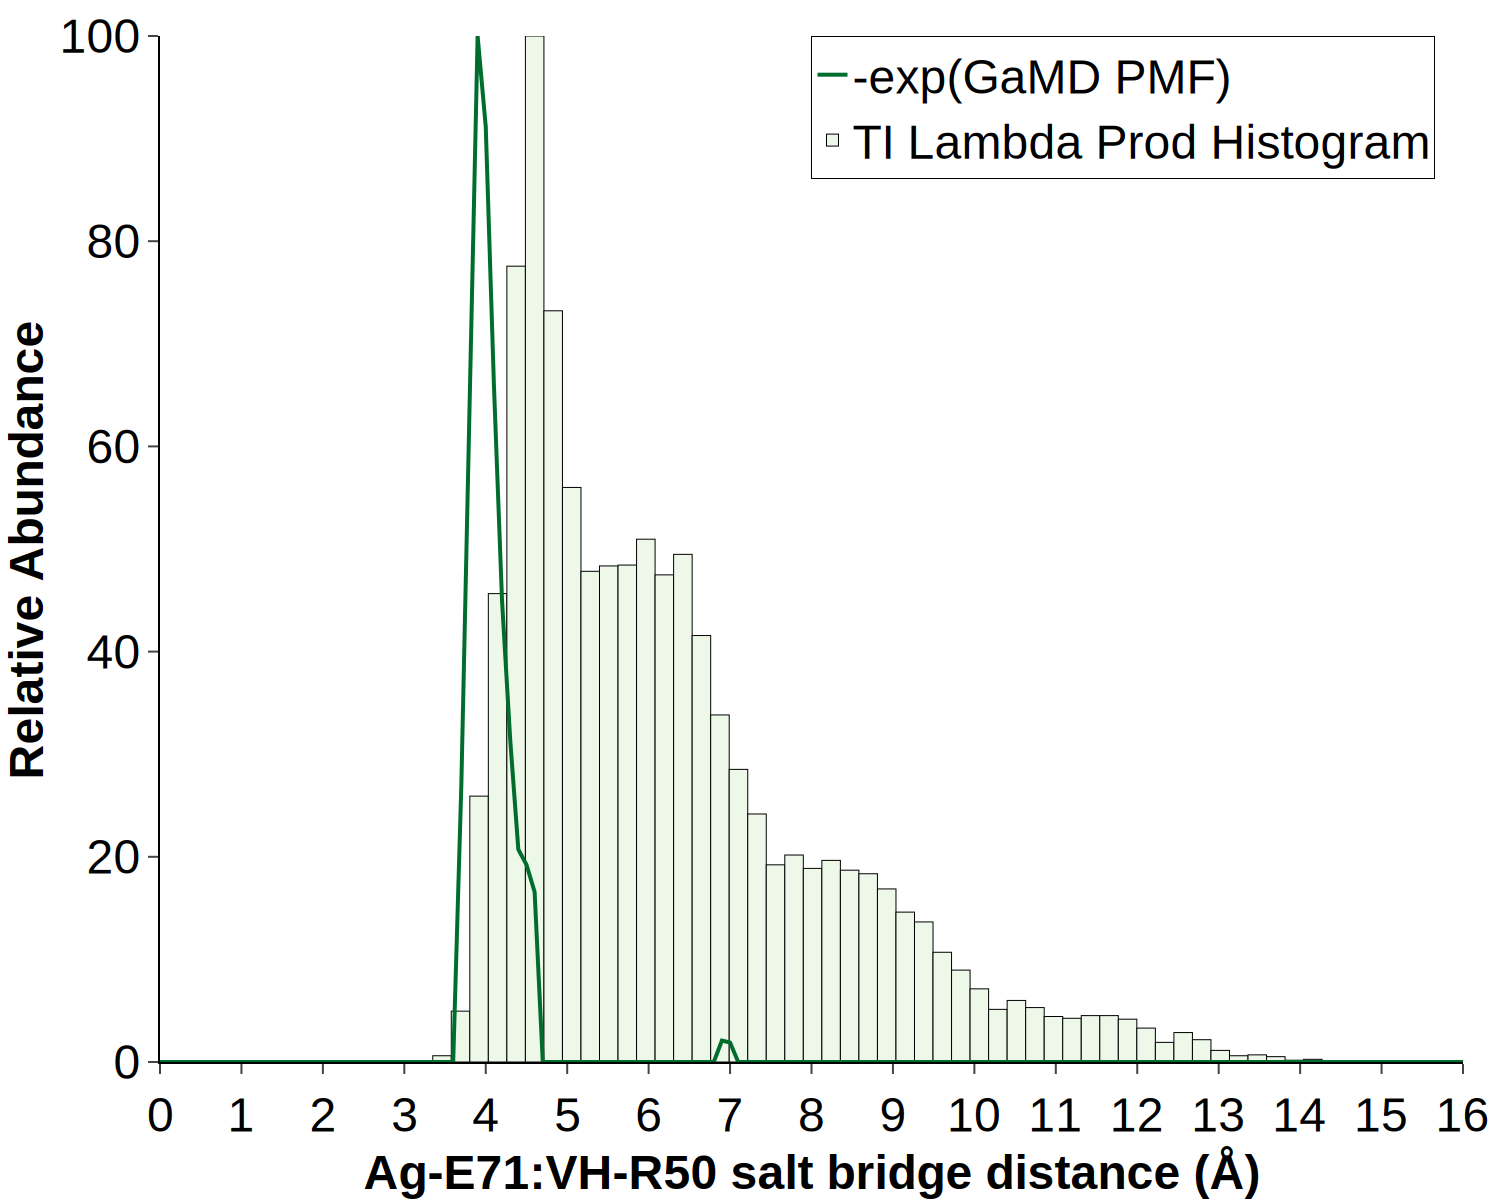

In [27]:
fig_oneStep = plot_pmf_TI_1D_fig(E71_R399, geom_dvdls_oneStep, "E71_R399_ion", scaler=100, bins=50).update_layout(
    width=1500,
    height=1200,
    barmode="overlay",
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),
    legend=dict(
        font=dict(size=48, color="black", family="Arial"),
        bordercolor="black",
        borderwidth=1,
        x=0.5, y=1
    )
).update_xaxes(
    range=[0,16],
    showline=True,
    linewidth=2,
    linecolor="black",
    dtick=1.0,
    ticks="outside", ticklen=10, tickwidth=2,
    tickfont=dict(size=48, color="black", family="Arial"),
    title=dict(
        text="<b>Ag-E71:VH-R50 salt bridge distance (Å)</b>" ,
        font=dict(family="Arial", size=48, color="black")
    )
).update_yaxes(
    range=[0, 100],
    linewidth=2,
    linecolor="black",
    tickfont=dict(size=48, color="black", family="Arial"),
    ticks="outside", ticklen=10, tickwidth=2,
    title=dict(
        text="<b>Relative Abundance</b>",
        font=dict(family="Arial", size=48, color="black")
    )
)
fig_oneStep.show(renderer="svg")


#### Using NMR restraints to enforce the salt bridge during the one-step transformation

Like before, we use NMR restraints again in the one-step transformation to ensure that the energetically influential VH-R50...Ag-E71 salt bridge is retained.

In [31]:
# bound state charging step
os.chdir("../../TI_data/VH-R50A")
geom_dvdls_oneStep_rst = pd.read_csv("R50A_oneStep_rst_bound.csv")


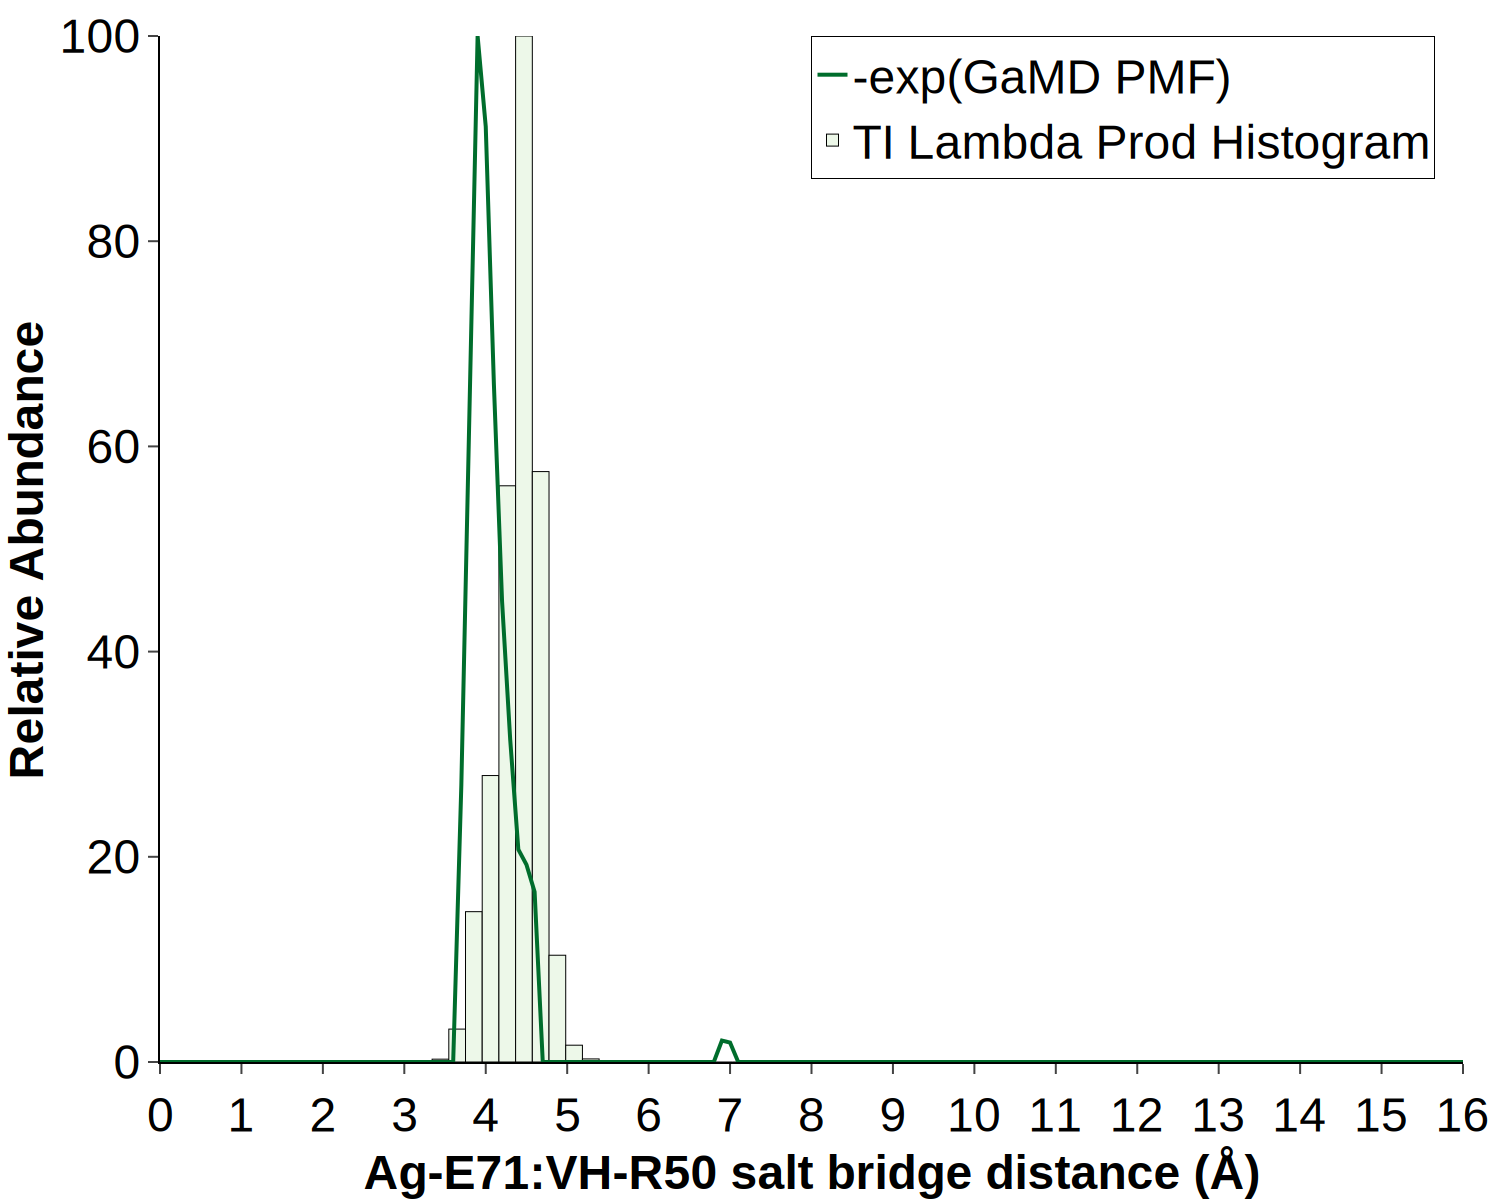

In [32]:
fig_oneStep_rst = plot_pmf_TI_1D_fig(E71_R399, geom_dvdls_oneStep_rst, "E71_R399_ion", scaler=100, bins=300).update_layout(
    width=1500,
    height=1200,
    barmode="overlay",
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),
    legend=dict(
        font=dict(size=48, color="black", family="Arial"),
        bordercolor="black",
        borderwidth=1,
        x=0.5, y=1
    )
).update_xaxes(
    range=[0,16],
    showline=True,
    linewidth=2,
    linecolor="black",
    dtick=1.0,
    ticks="outside", ticklen=10, tickwidth=2,
    tickfont=dict(size=48, color="black", family="Arial"),
    title=dict(
        text="<b>Ag-E71:VH-R50 salt bridge distance (Å)</b>" ,
        font=dict(family="Arial", size=48, color="black")
    )
).update_yaxes(
    range=[0, 100],
    linewidth=2,
    linecolor="black",
    tickfont=dict(size=48, color="black", family="Arial"),
    ticks="outside", ticklen=10, tickwidth=2,
    title=dict(
        text="<b>Relative Abundance</b>",
        font=dict(family="Arial", size=48, color="black")
    )
)
fig_oneStep_rst.show(renderer="svg")


In [33]:
dG_bd_oneStep_rst = dvdls_oneStep_rst.groupby("Lambda").mean()["weight_dvdl"].sum()
ddG_oneStep_rst = dG_bd_oneStep_rst - dG_ubd_oneStep

print("Original ddG (one step): ")
print(f"{round(ddG_oneStep, 4)} kcal/mol")

print("ddG with NMR restraints (one step): ")
print(f"{round(ddG_oneStep_rst, 4)} kcal/mol")

print()
print("Empirical value: ")
print(f"{empirical_value} kcal/mol")

Original ddG (one step): 
2.2748 kcal/mol
ddG with NMR restraints (one step): 
4.0657 kcal/mol

Empirical value: 
4.58 kcal/mol
